In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
from functools import partial
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from scipy.stats import percentileofscore
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [4]:
# # currently trained only on 'clath_aux+gak_a7d2_new'
# # dsets = ['clath_aux+gak_new']
# dsets = ['clath_aux_dynamin']
# splits = ['test']
# # feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

# #feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
#               #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
# meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
# dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
# print('type', type(dfs))

dsets = ['vps4_snf7']
splits = ['test']
length = 40
#     padding = 'end'
feat_name = 'X_same_length_extended_normalized' # include buffer X_same_length_normalized
outcome_def = 'Y_sig_mean_normalized'
outcome_binary = 'y_consec_sig'
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized', outcome_binary]
lifetime_threshold = 3

dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets,
                                         splits=splits,
                                         filter_hotspots=True,
                                         filter_short=True,
                                         lifetime_threshold=lifetime_threshold,
                                         hotspots_threshold=25,
                                         meta=meta,
                                         normalize=False)

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


In [5]:
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL_VPS, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']


# add preds
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

acc 0.637 vs baseline 0.81


# scatter plots

In [ ]:
plt.figure(figsize=(15, 6), dpi=250)
plt.subplot(121)

ys = df['Y_sig_mean_normalized'].values
preds_perc = preds # [percentileofscore(ys, score=p) for p in preds]
plt.plot(ys, preds_perc, 'o', alpha=0.2)
plt.ylabel('Predictions')
plt.xlabel('Groundtruth Regression (vps sig mean)')

plt.subplot(122)
ys = df['Y_max'].values
preds_perc = preds # [percentileofscore(ys, score=p) for p in preds]
plt.plot(ys, preds_perc, 'o', alpha=0.2)
plt.ylabel('Predictions')
plt.xlabel('Groundtruth Regression (vps4 max)')

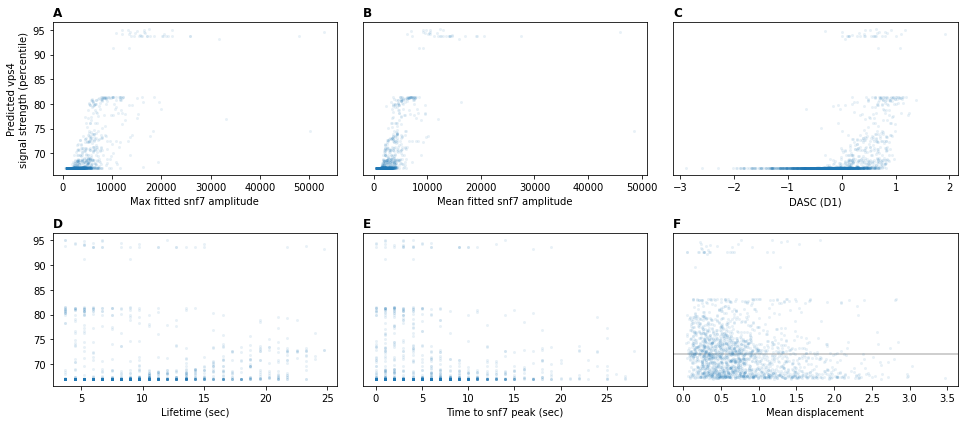

In [8]:
ys = df['Y_sig_mean_normalized'].values
preds_perc = [percentileofscore(ys, score=p) for p in preds]

R, C = 2, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))

plt.subplot(R, C, 1)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_max'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Max fitted snf7 amplitude')
plt.ylabel('Predicted vps4\nsignal strength (percentile)')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
# plt.axhline(0, color='gray', alpha=0.5)
plt.yticks([])
plt.plot(df['X_mean'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Mean fitted snf7 amplitude')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_d1'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('DASC (D1)')
plt.yticks([])
plt.title('C', loc='left', fontweight='bold')

plt.subplot(R, C, 4)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['lifetime'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Lifetime (sec)')
# plt.ylabel('Predicted auxilin\nsignal strength')
# plt.yticks([])
plt.title('D', loc='left', fontweight='bold')

plt.subplot(R, C, 5)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_peak_idx'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Time to snf7 peak (sec)')
plt.yticks([])
plt.title('E', loc='left', fontweight='bold')

plt.subplot(R, C, 6)
plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['mean_total_displacement'], df['preds'], '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Mean displacement')
plt.yticks([])
plt.title('F', loc='left', fontweight='bold')

plt.tight_layout()
# viz.savefig('top_feats_scatter')
plt.show()

# colored scatter plot (deprecated)

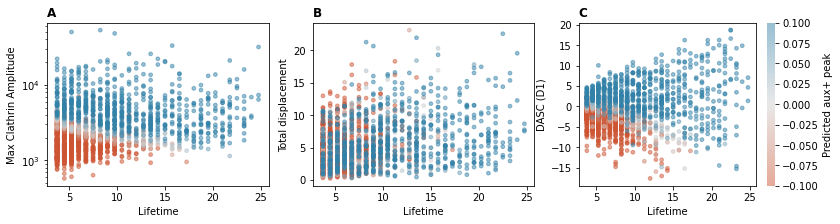

In [9]:
R, C = 1, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))
plt.subplot(R, C, 1)
plt.scatter(df['lifetime'], df['X_max'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Max Clathrin Amplitude')
plt.yscale('log')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
plt.scatter(df['lifetime'], df['mean_total_displacement'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Total displacement')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
plt.scatter(df['lifetime'], df['X_d1'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('DASC (D1)')
plt.title('C', loc='left', fontweight='bold')
cb = plt.colorbar(label='Predicted aux+ peak')
cb.outline.set_visible(False)
viz.savefig('top_feats_scatter')